## Ritesh Narayan Das

##### Aim: Analyze a signal (time-series data) using a combination of Fourier Transform and curve fitting. The goal is to find the dominant frequencies present in the signal and fit a multi-sinusoidal model to reconstruct the original signal.

#### Approach 1: Using Fourier Transform + Curve Fitting

#### Step 1: Data Reading and Preprocessing

I used x<20 for training, and x>=20 for testing purposes.

In [50]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Step 1: Load the CSV file
data = pd.read_csv('scr-dataset.csv')

# Extract x and y data from the dataset
x_data = data['x'].values
y_data = data['y'].values

# Step 2: Split data into training (x < 20) and testing (x >= 20)
train_mask = x_data < 20
test_mask = x_data >= 20

x_train = x_data[train_mask]
y_train = y_data[train_mask]

x_test = x_data[test_mask]
y_test = y_data[test_mask]

#### Step 2: Apply FFT to convert the time-domain signal into the frequency domain
We compute the discrete Fourier Transform (DFT) of the signal. The output `yf` contains complex values representing the amplitude and phase of different frequency components. We generate the frequency bins `(xf)` associated with each component from the FFT output. Only the first half of the frequencies are considered because the FFT result is symmetric.

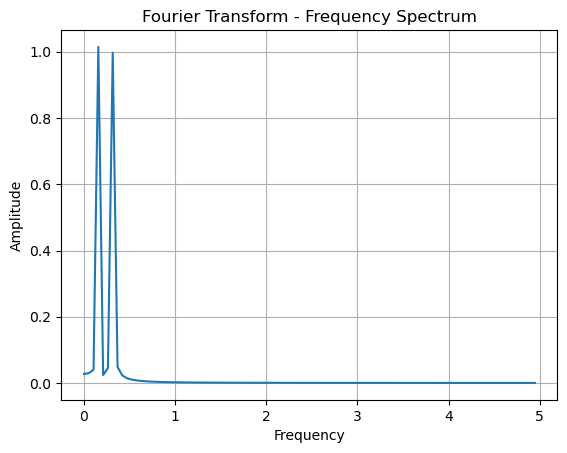

In [51]:
# Step 3: Perform Fast Fourier Transform (FFT) on the training data
N = len(x_train)
T = x_train[1] - x_train[0]  # Sampling interval

# Perform FFT
yf = fft(y_train)
xf = fftfreq(N, T)[:N//2]

# Plot the Fourier Transform (Frequency Spectrum)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('Fourier Transform - Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

#### Step 3: Detect the dominant frequencies present in the signal
We get the real magnitude of the FFT Result and normalize it. We only consider those peaks which have a significant amplitude >0.05 so that noise if filtered out.

In [52]:
amplitudes = 2.0 / N * np.abs(yf[:N//2])
peaks, _ = find_peaks(amplitudes, height=0.05)  # Adjust the height threshold as needed

# Extract the dominant frequencies and amplitudes
dominant_freqs = xf[peaks]
dominant_amplitudes = amplitudes[peaks]
print("Dominant Frequencies and Amplitudes:")
for freq, amp in zip(dominant_freqs, dominant_amplitudes):
    print(f"Frequency: {freq:.3f}, Amplitude: {amp:.3f}")

Dominant Frequencies and Amplitudes:
Frequency: 0.158, Amplitude: 1.014
Frequency: 0.316, Amplitude: 0.997


#### Step 4: Model
We define a model that sums multiple sinusoidal waves to represent the signal. This model will be used to fit the original data. The curve-fitting algorithm needs an initial estimate of the parameters. The code uses the dominant frequencies and amplitudes detected earlier as initial guesses for each sinusoidal component. The `curve_fit` function performs the actual fitting.

In [53]:
# Step 5: Define the multi-sinusoidal model based on the detected frequencies
def multi_sinusoidal(x, *params):
    D = params[-1]  # Offset
    y = np.zeros_like(x) + D
    for i in range(0, len(params)-1, 3):
        A = params[i]
        f = params[i+1]
        phi = params[i+2]
        y += A * np.sin(2 * np.pi * f * x + phi)
    return y

# Step 6: Set initial guesses for curve fitting on training data
initial_guess = []
for amp, freq in zip(dominant_amplitudes, dominant_freqs):
    initial_guess.extend([amp, freq, 0])  # Amplitude, frequency, initial phase
initial_guess.append(0)  # Guess for the offset

# Fit the multi-sinusoidal model to the training data
params, _ = curve_fit(multi_sinusoidal, x_train, y_train, p0=initial_guess)
# Step 7: Test the model on the test data
y_pred = multi_sinusoidal(x_test, *params)

# Step 8: Calculate the mean squared error between the predicted and actual test data
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test data: {mse:.5f}")

Mean Squared Error on test data: 0.00000


#### Step 5: Reconstruct the signal
We pass the fitted parameters into the `multi_sinusoidal` function to generate the reconstructed signal.

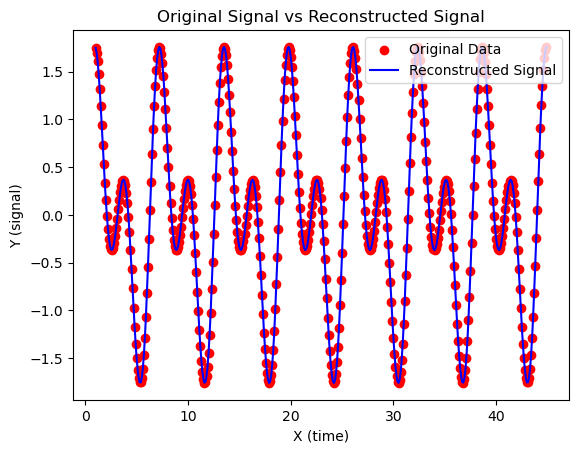

In [54]:
# Plot the original data and reconstructed signal
reconstructed_signal = multi_sinusoidal(x_data, *params)
plt.scatter(x_data, y_data, label='Original Data', color='red')
plt.plot(x_data, reconstructed_signal, label='Reconstructed Signal', color='blue')
plt.title('Original Signal vs Reconstructed Signal')
plt.xlabel('X (time)')
plt.ylabel('Y (signal)')
plt.legend()
plt.show()

#### Step 6: Print the Fitted Parameters
We display the parameters obtained from the curve-fitting process. We also draw graphs to visualise that our reconstructed signal perfectly fits the train as well as test data.

In [55]:
print("Fitted parameters:")
for i in range(0, len(params)-1, 3):
    print(f"Amplitude: {params[i]:.3f}, Frequency: {params[i+1]:.3f}, Phase: {params[i+2]:.3f}")
print(f"Offset: {params[-1]:.3f}")

Fitted parameters:
Amplitude: 1.000, Frequency: 0.159, Phase: -0.000
Amplitude: 1.000, Frequency: 0.318, Phase: 0.000
Offset: -0.000


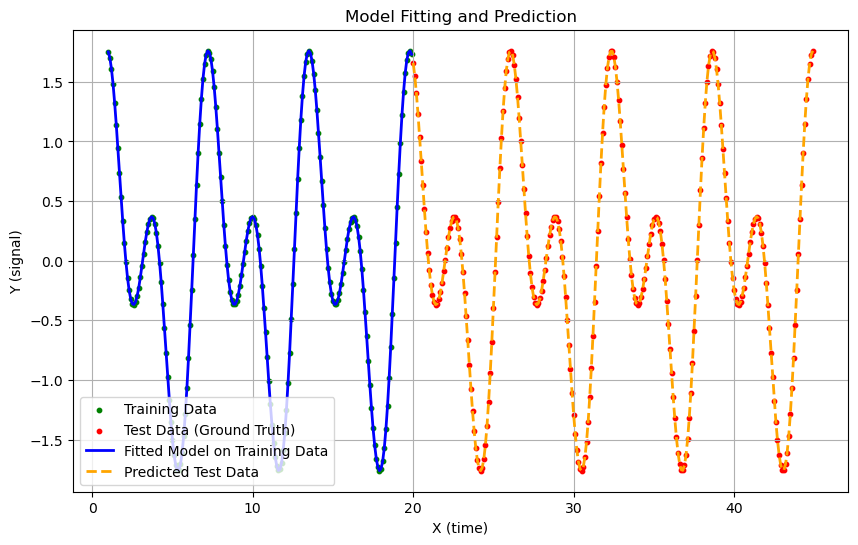

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, label='Training Data', color='green', s=10)  # Training data points
plt.scatter(x_test, y_test, label='Test Data (Ground Truth)', color='red', s=10)  # Test data points
plt.plot(x_train, multi_sinusoidal(x_train, *params), label='Fitted Model on Training Data', color='blue', linewidth=2)  # Fitted curve on train data
plt.plot(x_test, y_pred, label='Predicted Test Data', color='orange', linewidth=2, linestyle='--')  # Predicted test data
plt.title('Model Fitting and Prediction')
plt.xlabel('X (time)')
plt.ylabel('Y (signal)')
plt.legend()
plt.grid(True)
plt.show()


#### Step 7: Desired Result
We display the desired output in the f(x) format.

In [57]:
fitted_function = "f(x) = "
for i in range(0, len(params)-1, 3):
    A = params[i]
    f = params[i+1]
    phi = params[i+2]
    fitted_function += f"{A:.3f} * sin(2 * pi * {f:.3f} * x + {phi:.3f}) + "
D = params[-1]
fitted_function += f"{D:.3f}"  # Add the constant offset

print("Fitted function:")
print(fitted_function)

Fitted function:
f(x) = 1.000 * sin(2 * pi * 0.159 * x + -0.000) + 1.000 * sin(2 * pi * 0.318 * x + 0.000) + -0.000


In [58]:
import math
def fitted_function_eval(x, params):
    result = 0
    for i in range(0, len(params)-1, 3):
        A = params[i]
        f = params[i+1]
        phi = params[i+2]
        result += A * math.sin(2 * math.pi * f * x + phi)
    result += params[-1]  # Add the constant offset
    return result

# Take user input for x
x = float(input("Enter a value for x: "))
print(params)
# Calculate the value of the fitted function at x
value = fitted_function_eval(x, params)

# Display the result
print(f"The value of the fitted function at x = {x} is: {value:.3f}")

[ 1.00000000e+00  1.59154943e-01 -4.35649822e-09  1.00000000e+00
  3.18309885e-01  4.23170859e-08 -1.42105167e-09]
The value of the fitted function at x = 50.0 is: -0.769


In [60]:
import math

# Define the parameters
params = [1.000, 0.159, -0.000, 1.000, 0.318, 0.000, -0.000]  # example params

# Construct the fitted function string
fitted_function = "f(x) = "
for i in range(0, len(params)-1, 3):
    A = params[i]
    f = params[i+1]
    phi = params[i+2]
    fitted_function += f"{A:.3f} * math.sin(2 * math.pi * {f:.3f} * x + {phi:.3f}) + "
D = params[-1]
fitted_function += f"{D:.3f}"  # Add the constant offset

# Display the fitted function
print("Fitted function:")
print(fitted_function)

# Function to evaluate the fitted function
def fitted_function_eval(x, params):
    result = 0
    for i in range(0, len(params)-1, 3):
        A = params[i]
        f = params[i+1]
        phi = params[i+2]
        result += A * math.sin(2 * math.pi * f * x + phi)
    result += params[-1]  # Add the constant offset
    return result

# Evaluate the function for x = 50
x = 50
value = fitted_function_eval(x, params)
print(params)
# Display the result
print(f"The value of the fitted function at x = {x} is: {value:.3f}")


Fitted function:
f(x) = 1.000 * math.sin(2 * math.pi * 0.159 * x + -0.000) + 1.000 * math.sin(2 * math.pi * 0.318 * x + 0.000) + -0.000
[1.0, 0.159, -0.0, 1.0, 0.318, 0.0, -0.0]
The value of the fitted function at x = 50 is: -0.897
